In [1]:
import torch
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
import scipy.io
import numpy as np

# Load the .mat file
file_path = '../EV_Rank_1_52_RBs_50_UEs_1000_snaps.mat'
data = scipy.io.loadmat(file_path)

# Inspect the structure of the loaded data
data.keys()


dict_keys(['__header__', '__version__', '__globals__', 'EV_re_im_split'])

In [5]:
# Extract the relevant data
EV_data = data['EV_re_im_split']

# Check the shape and structure of the extracted data
print(EV_data.shape)

(50, 1000, 832)


In [6]:
data = EV_data

In [7]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [8]:
data_flattened = data.reshape(data.shape[0], -1)  # shape becomes (2100, 398*256)


In [9]:
data = data_flattened

In [10]:
data.shape

(50, 832000)

In [11]:
# Parameters
n_samples = 50
n_timesteps = 832000
window_size = 10
test_size = 0.2  # 20% for testing

# Initialize a list to hold models for each UE
models = []

# Initialize lists to hold performance evaluation data
predictions = []
actuals = []

In [12]:
for ue in range(n_samples):
    # Extract data for this specific UE
    ue_data = data[ue, :]  # Shape: (n_timesteps,)
    
    # Create rolling window pairs (input sequences and targets)
    X_ue = []
    y_ue = []
    
    for i in range(len(ue_data) - window_size):
        X_ue.append(ue_data[i:i + window_size])
        y_ue.append(ue_data[i + window_size])
    
    X_ue = np.array(X_ue)
    y_ue = np.array(y_ue)
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_ue, y_ue, test_size=test_size, random_state=42)
    
    # Initialize the XGBoost model
    model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, objective='reg:squarederror')
    
    # Train the model on the training set
    model.fit(X_train, y_train)
    
    # Make predictions on the testing set
    y_pred = model.predict(X_test)
    
    # Save the predictions and actuals for evaluation
    predictions.append(y_pred)
    actuals.append(y_test)
    
    # Save the model for this UE
    models.append(model)

In [13]:
import pandas as pd

# Initialize an empty list to store DataFrames for each UE
all_results = []

# Iterate through the predictions and actuals stored previously
for ue_index, (y_pred, y_test) in enumerate(zip(predictions, actuals)):
    # Create a DataFrame with columns for actual and predicted values
    results_df = pd.DataFrame({
        "Actual": y_test,
        "Predicted": y_pred
    })
    
    # Add an identifier for each UE
    results_df["UE"] = f"UE_{ue_index + 1}"
    
    # Append to the list of DataFrames
    all_results.append(results_df)

# Concatenate all DataFrames into one
final_results = pd.concat(all_results, ignore_index=True)

# Display the combined table
print(final_results)


           Actual  Predicted     UE
0       -0.205138  -0.105665   UE_1
1        0.016095  -0.010489   UE_1
2        0.028777   0.016423   UE_1
3        0.011449   0.008303   UE_1
4       -0.075095  -0.062249   UE_1
...           ...        ...    ...
8319895  0.099314   0.097995  UE_50
8319896  0.116107   0.115990  UE_50
8319897 -0.147824  -0.137637  UE_50
8319898  0.014798  -0.006399  UE_50
8319899 -0.192066  -0.177672  UE_50

[8319900 rows x 3 columns]


In [14]:
import matplotlib.pyplot as plt

# Function to visualize results for a specific UE
def visualize_predictions(ue_index):
    if ue_index < 0 or ue_index >= len(predictions):
        raise ValueError("Invalid UE index")
    
    # Retrieve the actual and predicted values for the given UE index
    y_pred = predictions[ue_index]
    y_test = actuals[ue_index]
    
    # Plot actual and predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[0:100], label="Actual", marker='o')
    plt.plot(y_pred[:100], label="Predicted", marker='x')
    plt.title(f"Actual vs. Predicted Values for UE {ue_index + 1}")
    plt.xlabel("Data Points")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)
    plt.show()




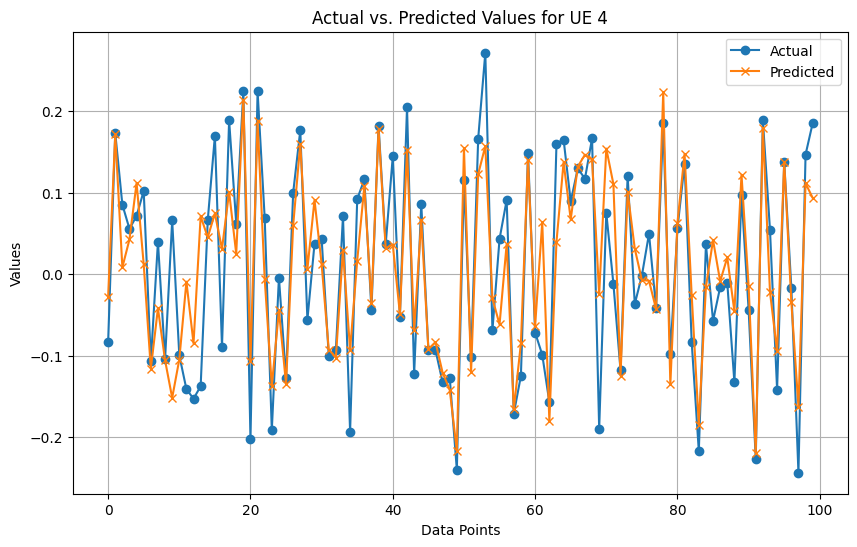

In [15]:
# Example usage to visualize the results for the first UE (index 0)
visualize_predictions(3)

In [16]:
# final_results.to_csv("ue_predictions_comparison.csv", index=False)

In [17]:
len(y_pred)

166398

In [18]:
len(y_test)

166398

In [19]:
len(X_train)

665592

In [20]:
len(y_train)

665592